In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets
import os
import SimpleITK as sitk
import radiomics
from radiomics import featureextractor, shape, shape2D
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler, PowerTransformer, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, recall_score, precision_score, f1_score, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import defaultdict
import datetime
import glob
from PIL import Image
import gc
import torch
from transformers import AutoTokenizer, AutoModel, BertTokenizer, BertModel


In [4]:

marksheet_path = r'Data\marksheet.csv'
source_PI_CAI = r'Data/picai_public_images'
source_PI_CAI_whole_gland_Guerbet23 = r'Data/picai_public_images/anatomical_delineations/whole_gland/AI/Guerbet23'
source_PI_CAI_Human = r'Data/picai_public_images/csPCa_lesion_delineations/human_expert/original'
source_PI_CAI_resampled = r'Data/t2w_spacing_resampled'
source_PI_CAI_resampled_whole_gland_Guerbet23 = r'Data/Guerbet23_resampled'
source_PI_CAI_resampled_Human = r'Data/Human_resampled'
def find_t2W_files(dir, combined_ids, fileinfo):
    dir = os.path.normpath(dir)
    t2w_file_paths = []

    for subdir, dirs, files in os.walk(dir):
        subdir = os.path.normpath(subdir)
        for file in files:
            if any(file.endswith(combined_id + fileinfo) for combined_id in combined_ids):
                t2w_file_paths.append(os.path.join(subdir, file))

    return t2w_file_paths

def preprocess_data(marksheet_df):
    print(f"Initial dataset length: {len(marksheet_df)}")

    # 1. Drop data with missing values in the column "PSA" or "Volume"
    preprocessed_marksheet_df = marksheet_df.dropna(subset=['psa'])
    print(f"Dataset length after dropping rows with missing psa: {len(preprocessed_marksheet_df)}")
     
    preprocessed_marksheet_df = preprocessed_marksheet_df.dropna(subset=['prostate_volume'])
    print(f"Dataset length after dropping rows with missing prostate volume: {len(preprocessed_marksheet_df)}")
    # 2. Filter out patients with no biopsy
    biopsy_filter = preprocessed_marksheet_df['histopath_type'].isin(['MRBx', 'SysBx', 'SysBx+MRBx'])
    preprocessed_marksheet_df = preprocessed_marksheet_df[biopsy_filter]
    print(f"Dataset length after filtering biopsies: {len(preprocessed_marksheet_df)}")

    # 3. Convert case_csPCa to binary (1: True, 0: False)
    preprocessed_marksheet_df['case_csPCa'] = preprocessed_marksheet_df['case_csPCa'].apply(lambda x: 1 if x.upper() == 'YES' else 0)
    
    # Combined ids for use as a unique identifier
    sorted_patient_id = marksheet_df['patient_id']
    sorted_study_id = marksheet_df['study_id']
    combined_ids = sorted_patient_id.astype(str) + '_' + sorted_study_id.astype(str)

    return preprocessed_marksheet_df, combined_ids

def save_df(df, dir, filename, gland_type):
    path = os.path.join(dir, f"{filename}_{gland_type}.csv")
    df.to_csv(path, index=False)
    print(f"File saved as {path}")

def calculate_psad(df):
    mask = df['psad'].isna() & df['psa'].notna() & df['prostate_volume'].notna()
    df.loc[mask, 'psad'] = (df.loc[mask, 'psa'] / df.loc[mask, 'prostate_volume']).round(2)
    
    return df


In [5]:
marksheet_df = pd.read_csv(marksheet_path)
Preprocessed_marksheet_df, combined_ids = preprocess_data(marksheet_df)

Preprocessed_marksheet_df = calculate_psad(Preprocessed_marksheet_df)
save_df(Preprocessed_marksheet_df, 'Data', 'Preprocessed_marksheet', 'all')
Preprocessed_marksheet_df


Initial dataset length: 1500
Dataset length after dropping rows with missing psa: 1460
Dataset length after dropping rows with missing prostate volume: 1439
Dataset length after filtering biopsies: 945
File saved as Data\Preprocessed_marksheet_all.csv


,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa,center
0,10000,1000000,2019-07-02,73,7.70,0.14,55.0,MRBx,0+0,0,0,0,PCNN
3,10003,1000003,2019-04-05,72,13.00,0.18,71.5,SysBx,0+0,0,0,0,ZGT
4,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,0,RUMC
5,10005,1000005,2012-07-18,64,12.10,0.24,51.0,MRBx,"4+3,0+0","3,0",3,1,RUMC
6,10006,1000006,2020-10-23,73,6.20,0.23,27.0,SysBx+MRBx,"0+0,3+3","0,1",1,0,ZGT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,11471,1001495,2012-08-25,71,12.50,0.21,62.0,MRBx,"3+4,N/A,3+3","2,1",2,1,RUMC
1496,11472,1001496,2019-06-28,81,5.28,0.12,44.0,SysBx+MRBx,3+4,2,2,1,RUMC
1497,11473,1001497,2017-09-24,56,29.60,0.34,87.0,MRBx,0+0,0,0,0,RUMC
1498,11474,1001498,2016-05-03,71,12.00,0.14,83.0,MRBx,3+3,1,1,0,PCNN


203 388 340


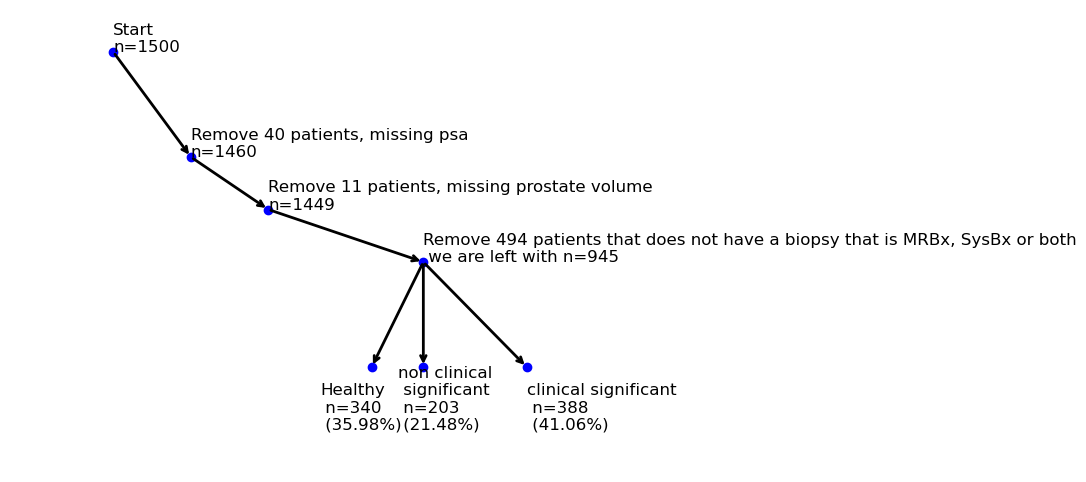

In [5]:
df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')
df_exploded = df

def get_highest_gleason_score(gleason_scores):
    """
    Function to get the highest Gleason score from a list of scores.
    """
    score_mapping = {
        "0+0": 0,
        "3+3": 1,
        "3+4": 2,
        "4+3": 3,
        "4+4": 4,
        "5+4": 5,
        "4+5": 6,
        "5+5": 7
    }
    highest_score = max(gleason_scores, key=lambda x: score_mapping.get(x, -1))
    return highest_score

# Split the lesion_GS column by comma and explode the DataFrame to handle multiple scores
df['lesion_GS'] = df['lesion_GS'].str.split(',')
df_exploded = df.explode('lesion_GS').reset_index(drop=True)

# Group by patient_id and select the highest Gleason score for each patient
df_highest_gleason = df_exploded.groupby('patient_id')['lesion_GS'].apply(lambda x: get_highest_gleason_score(x)).reset_index()

# Merge the highest Gleason scores back to the original DataFrame
df = df.drop(columns=['lesion_GS']).merge(df_highest_gleason, on='patient_id')

# Calculate the counts for each category
gleason_7_low = df[df["lesion_GS"] == "3+3"].shape[0]
gleason_7_high = df[df["lesion_GS"].isin(["3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])].shape[0]
negative_biopsy = df[df["lesion_GS"] == "0+0"].shape[0]

# Print the counts
print(gleason_7_low, gleason_7_high, negative_biopsy)

# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot([0.2, 0.35, 0.5, 0.8, 0.7, 0.8, 1], [2, 1.5, 1.25, 1, 0.5, 0.5, 0.5], 'o', color='blue')
ax.annotate("", xy=(0.35, 1.5), xytext=(0.2, 2), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.5, 1.25), xytext=(0.35, 1.5), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.8, 1), xytext=(0.5, 1.25), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.7, 0.5), xytext=(0.8, 1), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.8, 0.5), xytext=(0.8, 1), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(1, 0.5), xytext=(0.8, 1), arrowprops=dict(arrowstyle="->", lw=2))

ax.text(0.2, 2, "Start\nn=1500", fontsize=12)
ax.text(0.35, 1.5, "Remove 40 patients, missing psa \nn=1460", fontsize=12)
ax.text(0.5, 1.25, "Remove 11 patients, missing prostate volume \nn=1449", fontsize=12)
ax.text(0.8, 1, "Remove 494 patients that does not have a biopsy that is MRBx, SysBx or both\n we are left with n=945", fontsize=12)
ax.text(0.6, 0.2, f"Healthy\n n={negative_biopsy} \n ({(negative_biopsy / 945) * 100:.2f}%)", fontsize=12)
ax.text(0.75, 0.2, f"non clinical \n significant \n n={gleason_7_low} \n ({(gleason_7_low / 945) * 100:.2f}%) " , fontsize=12)
ax.text(1, 0.2, f"clinical significant\n n={gleason_7_high} \n ({(gleason_7_high / 945) * 100:.2f}%)", fontsize=12)

ax.set_xlim(0, 1.2)
ax.set_ylim(0, 2.2)
ax.axis("off")

plt.show()

In [ ]:
# df = Preprocessed_marksheet_df
# def count_case_csPCa(df):
#     """
#     Function to count the number of positive (1) and negative (0) cases in the case_csPCa column.
#     """
#     positive_cases = df[df['case_csPCa'] == 1].shape[0]
#     negative_cases = df[df['case_csPCa'] == 0].shape[0]
    
#     return positive_cases, negative_cases

# # Count the positive and negative cases
# positive_cases, negative_cases = count_case_csPCa(df)

# # Print the results
# print(f"Number of positive cases (1): {positive_cases}")
# print(f"Number of negative cases (0): {negative_cases}")

Number of positive cases (1): 393
Number of negative cases (0): 552


In [7]:
def median_iqr(series):
    return f"{series.median():.2f} ({series.quantile(0.25):.2f}-{series.quantile(0.75):.2f})"



def generate_summary_table(df):
    N = len(df)
    age = df['patient_age']
    psa = df['psa']
    prostate_volume = df['prostate_volume']
    psad = df['psad']
    
    age_mean_std = f"{age.mean():.2f},\u2009+-\u2009 {age.std():.2f}"
    psa_median_iqr = median_iqr(psa)
    psad_median_iqr = median_iqr(psad)
    prostate_volume_median_std = f"{prostate_volume.median():.2f},\u2009+-\u2009 {prostate_volume.std():.2f}"


    vol_35 = prostate_volume[prostate_volume < 35].shape[0]
    vol_35_50 = prostate_volume[(prostate_volume >= 35) & (prostate_volume < 50)].shape[0]
    vol_50 = prostate_volume[prostate_volume >= 50].shape[0]

    biopsy_counts = df['histopath_type'].value_counts()
    biopsy_types = {
        'MRBx': biopsy_counts.get('MRBx', 0),
        'SysBx': biopsy_counts.get('SysBx', 0),
        'SysBx+MRBx': biopsy_counts.get('SysBx+MRBx', 0)
    }
    df['lesion_GS'] = df['lesion_GS'].str.split(',')
    df_exploded = df.explode('lesion_GS').reset_index(drop=True)

# Group by patient_id and select the highest Gleason score for each patient
    df_highest_gleason = df_exploded.groupby('patient_id')['lesion_GS'].apply(lambda x: get_highest_gleason_score(x)).reset_index()

# Merge the highest Gleason scores back to the original DataFrame
    df = df.drop(columns=['lesion_GS']).merge(df_highest_gleason, on='patient_id')

    gleason_7_low = df[df["lesion_GS"] == "3+3"].shape[0]
    gleason_7_high = df[df["lesion_GS"].isin(["3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])].shape[0]
    negative_biopsy = df[df["lesion_GS"] == "0+0"].shape[0]

    table_data = {
        'Age(Years)': age_mean_std,
        'PSA(ng/ml)': psa_median_iqr,
        'PSAD(ng/ml^2)': psad_median_iqr,
        'Prostate Volume(ml)': prostate_volume_median_std,
        "< 35 mL": f"{vol_35} ({(vol_35 / len(df)) * 100:.2f}%)",
        "35 - 50 mL": f"{vol_35_50} ({(vol_35_50 / len(df)) * 100:.2f}%)",
        "> 50 mL": f"{vol_50} ({(vol_50 / len(df)) * 100:.2f}%)",
        "Biopsy type": "".join([f"{k}: {v} ({(v / len(df)) * 100:.2f}%)" for k, v in biopsy_types.items()]),
        "Biopsy results:": "",
        "Negative:": f"{negative_biopsy} ({(negative_biopsy / len(df)) * 100:.2f}%)",
        "Gleason score ≤7:": f"{gleason_7_low} ({(gleason_7_low / len(df)) * 100:.2f}%)",
        "Gleason score >7:": f"{gleason_7_high} ({(gleason_7_high / len(df)) * 100:.2f}%)",
    }
    table_df = pd.DataFrame.from_dict(table_data, orient='index', columns=[f'Patients ({N})'])
    return table_df
df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')
summary_table = generate_summary_table(df)
print(summary_table)


                                                        Patients (945)
Age(Years)                                             66.47, +-  7.05
PSA(ng/ml)                                           9.00 (6.10-14.00)
PSAD(ng/ml^2)                                         0.18 (0.11-0.28)
Prostate Volume(ml)                                   51.00, +-  31.49
< 35 mL                                                   197 (20.85%)
35 - 50 mL                                                245 (25.93%)
> 50 mL                                                   503 (53.23%)
Biopsy type          MRBx: 529 (55.98%)SysBx: 211 (22.33%)SysBx+MRB...
Biopsy results:                                                       
Negative:                                                 340 (35.98%)
Gleason score ≤7:                                         203 (21.48%)
Gleason score >7:                                         388 (41.06%)


In [6]:
fileInfoT2w = '_t2w.mha'

fileInfo = '.nii.gz'
t2w_paths = find_t2W_files(source_PI_CAI, combined_ids, fileInfoT2w)
Guerbet23_nii_gz_paths = find_t2W_files(source_PI_CAI_whole_gland_Guerbet23, combined_ids, fileInfo)
Human_nii_gz_paths = find_t2W_files(source_PI_CAI_Human, combined_ids, fileInfo)

In [7]:
t2w_patient_ids = [path.split('\\')[-2] for path in t2w_paths]
Guerbet23_patient_ids = [path.split('\\')[-1].split("_")[0] for path in Guerbet23_nii_gz_paths]
Human_nii_gz_patient_ids = [path.split('\\')[-1].split("_")[0] for path in Human_nii_gz_paths]

t2w_df = pd.DataFrame({'patient_id': t2w_patient_ids, 'T2w_path': t2w_paths})
Guerbet23_df = pd.DataFrame({'Nii_gz_path': Guerbet23_nii_gz_paths, 'patient_id': Guerbet23_patient_ids})
Human_df = pd.DataFrame({'Nii_gz_path': Human_nii_gz_paths, 'patient_id': Human_nii_gz_patient_ids})

df_path_merged_Guerbet23 = pd.merge(t2w_df, Guerbet23_df, on='patient_id')
df_path_merged_Human = pd.merge(t2w_df, Human_df, on='patient_id')


Image shape: (31, 640, 640)


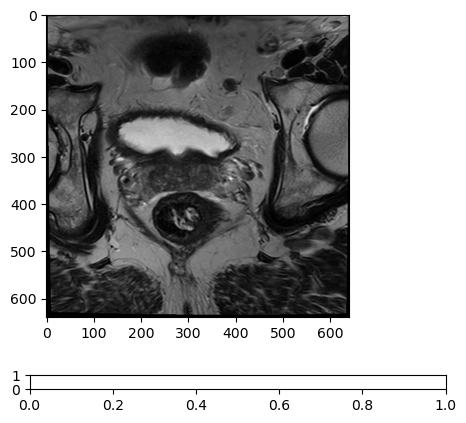

In [7]:
file_path = r"Data\picai_public_images\picai_public_images_fold0\10000\10000_1000000_t2w.mha"
image = sitk.ReadImage(file_path)
image_data = sitk.GetArrayFromImage(image)

print(f"Image shape: {image_data.shape}")

fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)

axlayer = plt.axes([0.25, 0.1, 0.65, 0.03])

ax.imshow(image_data[18, :, :], cmap='gray')

plt.show()

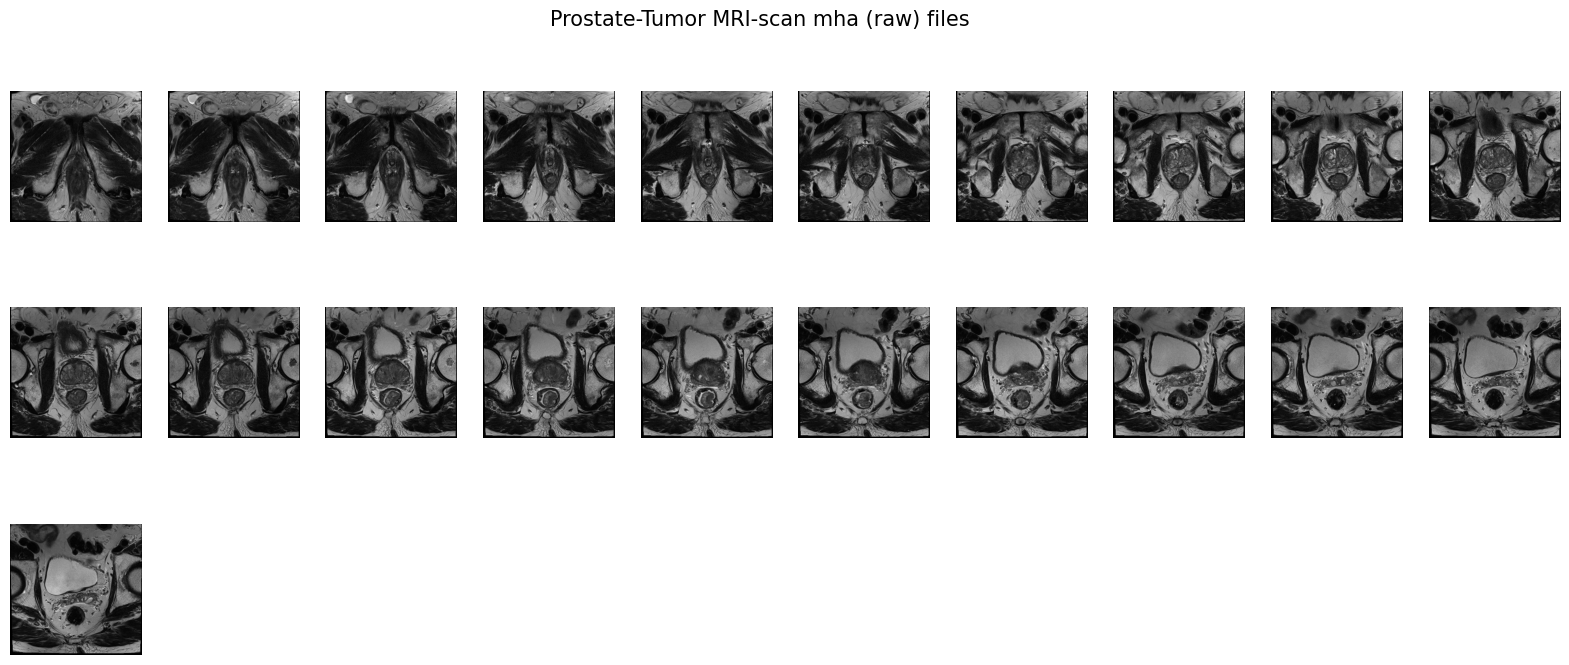

In [8]:
file_path = r"Data\picai_public_images\picai_public_images_fold1\10008\10008_1000008_t2w.mha"
image = sitk.ReadImage(file_path)
image_data = sitk.GetArrayFromImage(image)

if image_data.max() > 0:
    image_data = image_data / image_data.max()

num_slices = image_data.shape[0]

cols = 10
rows = int(np.ceil(num_slices / cols))

plt.figure(figsize=(20, rows * 2.5))
plt.gray()
plt.subplots_adjust(hspace=0.5)

for i in range(num_slices):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(image_data[i], cmap='gray')
    plt.axis('off')

plt.suptitle('Prostate-Tumor MRI-scan mha (raw) files', size=15)
plt.show()

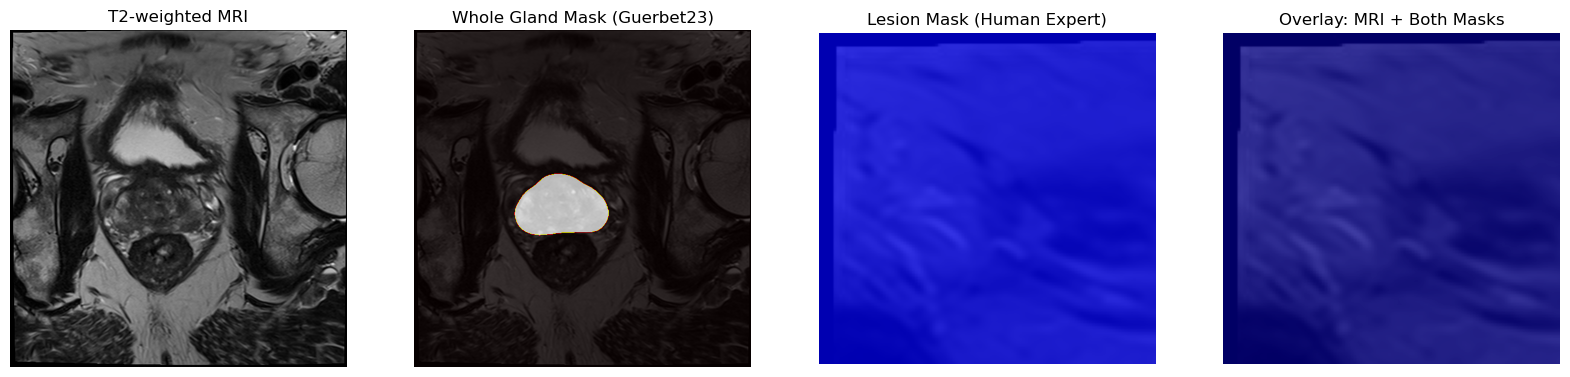

In [8]:
def load_nifti_image(file_path):
    img = sitk.ReadImage(file_path)
    return sitk.GetArrayFromImage(img) 

patient_id = df_path_merged_Guerbet23.iloc[0]['patient_id']  

t2w_path = df_path_merged_Guerbet23.iloc[0]['T2w_path']
guerbet23_mask_path = df_path_merged_Guerbet23.iloc[0]['Nii_gz_path']
human_mask_path = df_path_merged_Human.iloc[0]['Nii_gz_path']

t2w_image = load_nifti_image(t2w_path)
guerbet23_mask = load_nifti_image(guerbet23_mask_path)
human_mask = load_nifti_image(human_mask_path) 

t2w_image = t2w_image / np.max(t2w_image)

mid_slice = t2w_image.shape[0] // 2

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(t2w_image[mid_slice], cmap='gray')
ax[0].set_title("T2-weighted MRI")

ax[1].imshow(t2w_image[mid_slice], cmap='gray')
ax[1].imshow(guerbet23_mask[mid_slice], cmap='hot', alpha=0.7)
ax[1].set_title("Whole Gland Mask (Guerbet23)")

ax[2].imshow(t2w_image[mid_slice], cmap='gray')
ax[2].imshow(human_mask[mid_slice], cmap='winter', alpha=0.7)
ax[2].set_title("Lesion Mask (Human Expert)")

ax[3].imshow(t2w_image[mid_slice], cmap='gray')
ax[3].imshow(guerbet23_mask[mid_slice], cmap='hot', alpha=0.4)
ax[3].imshow(human_mask[mid_slice], cmap='winter', alpha=0.4)
ax[3].set_title("Overlay: MRI + Both Masks")

for a in ax:
    a.axis("off")

plt.show()

In [12]:
def find_significant_correlations(df, processed_subset, target_variable='case_csPCa', threshold=0.0):
    df['patient_id'] = df['patient_id'].astype(int)

    merge_df = pd.merge(processed_subset, df, left_on='patient_id', right_on='patient_id', how='left')
    merge_df.drop('patient_id', axis=1, inplace=True)
    correlation_matrix = merge_df.corr()
    absolute_correlation = correlation_matrix[target_variable].abs()
    significant_correlations = absolute_correlation[absolute_correlation > threshold].sort_values(ascending=False)
    significant_correlations_sorted = significant_correlations[significant_correlations.index != target_variable]
    significant_correlations_df = significant_correlations_sorted.reset_index()
    significant_correlations_df.columns = ['Feature', 'Correlation with '+target_variable]

    return significant_correlations_df


def evaluate_model_perfomance(model, X_train, y_train, X_test, y_test, name=""):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
    auc_score = auc(fpr, tpr)

    classification_report_str = classification_report(y_test, y_test_pred)

    metrics = {
        f'AUC_{name}': auc_score,
        f'Accuracy_{name}': test_accuracy,
        f'Sensitivity_{name}': recall_score(y_test, y_test_pred),
        f'Specificity_{name}': recall_score(y_test, y_test_pred, pos_label=0),
        f'F! Score_{name}': f1_score(y_test, y_test_pred),
    }

    return train_accuracy, test_accuracy, classification_report_str, metrics, fpr, tpr

def print_mean_and_std(results_df):
    for i, row in results_df.iterrows():
        model_name = row['model']

        print(f"Model: {model_name}")
        print("Cross-validation metrics (Mean, Standard Deviation):")

        metrics = ['AUC', 'Accuracy', 'Sensitivity', 'Precision', 'F1 Score']
        for metric in metrics:
            mean_val, sd_val = row[metric]
            print(f"{metric}: Mean = {mean_val:.4f}, SD = {sd_val:.4f}")
        print("\n--------------------------------------------------")

    return results_df[['model'] + metrics]

def evaluate_confusion_matrix(model, X_test, y_test, ax=None, name="", threshold=0.5, display= True):

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

    if ax is not None:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(ax=ax)
        ax.set_title(name)
    
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0

    metrics = {
        'Title:': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN
    }
    mse = mean_squared_error(y_test, y_pred_proba)
    r2 = r2_score(y_test, y_pred_proba)
    

    if display:
        print(f'Title: {name}')
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
        print(f"R2 Score: {r2}")
        print(f"Mean Squared Error: {mse}")
        print('----------------------------')

    return metrics, cm

def apply_scaling(scale='range'):
    if scale == 'outliers':
        scaler = RobustScaler()
    elif scale == 'range':
        scaler = MinMaxScaler()
    elif scale == 'non-gaussian':
        scaler = PowerTransformer()
    elif scale == 'sparse':
        scaler = MaxAbsScaler()
    elif scale == 'none':
        scaler = None  # No scaling
    else:
        scaler = StandardScaler()  # Default scaler

    return scaler

def generate_summary_table_train_test(df, X_train, X_test):
    N = len(df)
    age = df['patient_age']
    age_train = X_train['patient_age']
    age_test = X_test['patient_age']
    psa = df['psa']
    psa_train = X_train['psa']
    psa_test = X_test['psa']
    prostate_volume = df['prostate_volume']
    prostate_volume_train = X_train['prostate_volume']
    prostate_volume_test = X_test['prostate_volume']
    psad = df['psad']
    psad_train = X_train['psad']
    psad_test = X_test['psad']
    
    age_mean_std = f"{age.mean():.2f},\u2009+-\u2009 {age.std():.2f}"
    age_train_mean_std = f"{age_train.mean():.2f},\u2009+-\u2009 {age_train.std():.2f}"
    age_test_mean_std = f"{age_test.mean():.2f},\u2009+-\u2009 {age_test.std():.2f}"
    psa_median_iqr = median_iqr(psa)
    psa_train_median_iqr = median_iqr(psa_train)
    psa_test_median_iqr = median_iqr(psa_test)
    psad_median_iqr = median_iqr(psad)
    psad_train_median_iqr = median_iqr(psad_train)
    psad_test_median_iqr = median_iqr(psad_test)
    prostate_volume_median_std = f"{prostate_volume.median():.2f},\u2009+-\u2009 {prostate_volume.std():.2f}"
    prostate_volume_train_median_std = f"{prostate_volume_train.median():.2f},\u2009+-\u2009 {prostate_volume_train.std():.2f}"
    prostate_volume_test_median_std = f"{prostate_volume_test.median():.2f},\u2009+-\u2009 {prostate_volume_test.std():.2f}"

    vol_35 = prostate_volume[prostate_volume < 35].shape[0]
    vol_35_train = prostate_volume_train[prostate_volume_train < 35].shape[0]
    vol_35_test = prostate_volume_test[prostate_volume_test < 35].shape[0]
    vol_35_50 = prostate_volume[(prostate_volume >= 35) & (prostate_volume < 50)].shape[0]
    vol_35_50_train = prostate_volume_train[(prostate_volume_train >= 35) & (prostate_volume_train < 50)].shape[0]
    vol_35_50_test = prostate_volume_test[(prostate_volume_test >= 35) & (prostate_volume_test < 50)].shape[0]
    vol_50 = prostate_volume[prostate_volume >= 50].shape[0]
    vol_50_train = prostate_volume_train[prostate_volume_train >= 50].shape[0]
    vol_50_test = prostate_volume_test[prostate_volume_test >= 50].shape[0]

    biopsy_counts = df['histopath_type'].value_counts()
    biopsy_counts_train = X_train['histopath_type'].value_counts()
    biopsy_counts_test = X_test['histopath_type'].value_counts()
    biopsy_types = {
        'MRBx': biopsy_counts.get('MRBx', 0),
        'SysBx': biopsy_counts.get('SysBx', 0),
        'SysBx+MRBx': biopsy_counts.get('SysBx+MRBx', 0)
    }
    biopsy_types_train = {
        'MRBx': biopsy_counts_train.get('MRBx', 0),
        'SysBx': biopsy_counts_train.get('SysBx', 0),
        'SysBx+MRBx': biopsy_counts_train.get('SysBx+MRBx', 0)
    }
    biopsy_types_test = {
        'MRBx': biopsy_counts_test.get('MRBx', 0),
        'SysBx': biopsy_counts_test.get('SysBx', 0),
        'SysBx+MRBx': biopsy_counts_test.get('SysBx+MRBx', 0)
    }
    test_df = X_test
    train_df = X_train

    df['lesion_GS'] = df['lesion_GS'].str.split(',')
    train_df['lesion_GS'] = train_df['lesion_GS'].str.split(',')
    test_df['lesion_GS'] = test_df['lesion_GS'].str.split(',')

    df_exploded = df.explode('lesion_GS').reset_index(drop=True)
    train_df_exploded = train_df.explode('lesion_GS').reset_index(drop=True)
    test_df_exploded = test_df.explode('lesion_GS').reset_index(drop=True)

    df_highest_gleason = df_exploded.groupby('patient_id')['lesion_GS'].apply(lambda x: get_highest_gleason_score(x)).reset_index()
    train_df_highest_gleason = train_df_exploded.groupby('patient_id')['lesion_GS'].apply(lambda x: get_highest_gleason_score(x)).reset_index()
    test_df_highest_gleason = test_df_exploded.groupby('patient_id')['lesion_GS'].apply(lambda x: get_highest_gleason_score(x)).reset_index()

    df = df.drop(columns=['lesion_GS']).merge(df_highest_gleason, on='patient_id')
    train_df = train_df.drop(columns=['lesion_GS']).merge(train_df_highest_gleason, on='patient_id')
    test_df = test_df.drop(columns=['lesion_GS']).merge(test_df_highest_gleason, on='patient_id')

    gleason_7_low = df[df["lesion_GS"] == "3+3"].shape[0]
    gleason_7_low_train = train_df[train_df["lesion_GS"] == "3+3"].shape[0]
    gleason_7_low_test = test_df[test_df["lesion_GS"] == "3+3"].shape[0]
    gleason_7_high = df[df["lesion_GS"].isin(["3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])].shape[0]
    gleason_7_high_train = train_df[train_df["lesion_GS"].isin(["3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])].shape[0]
    gleason_7_high_test = test_df[test_df["lesion_GS"].isin(["3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])].shape[0]
    negative_biopsy = df[df["lesion_GS"] == "0+0"].shape[0]
    negative_biopsy_train = train_df[train_df["lesion_GS"] == "0+0"].shape[0]
    negative_biopsy_test = test_df[test_df["lesion_GS"] == "0+0"].shape[0]

    table_data = {
        'Age(Years)': [age_mean_std, age_train_mean_std, age_test_mean_std],
        'PSA(ng/ml)': [psa_median_iqr, psa_train_median_iqr, psa_test_median_iqr],
        'PSAD(ng/ml^2)': [psad_median_iqr, psad_train_median_iqr, psad_test_median_iqr],
        'Prostate Volume(ml)': [prostate_volume_median_std, prostate_volume_train_median_std, prostate_volume_test_median_std],
        "< 35 mL": [f"{vol_35} ({(vol_35 / len(df)) * 100:.2f}%)", f"{vol_35_train} ({(vol_35_train / len(X_train)) * 100:.2f}%)", f"{vol_35_test} ({(vol_35_test / len(X_test)) * 100:.2f}%)"],
        "35 - 50 mL": [f"{vol_35_50} ({(vol_35_50 / len(df)) * 100:.2f}%)", f"{vol_35_50_train} ({(vol_35_50_train / len(X_train)) * 100:.2f}%)", f"{vol_35_50_test} ({(vol_35_50_test / len(X_test)) * 100:.2f}%)"],
        "> 50 mL": [f"{vol_50} ({(vol_50 / len(df)) * 100:.2f}%)", f"{vol_50_train} ({(vol_50_train / len(X_train)) * 100:.2f}%)", f"{vol_50_test} ({(vol_50_test / len(X_test)) * 100:.2f}%)"],
        "Biopsy type": ["".join([f"{k}: {v} ({(v / len(df)) * 100:.2f}%)" for k, v in biopsy_types.items()]), "".join([f"{k}: {v} ({(v / len(X_train)) * 100:.2f}%)" for k, v in biopsy_types_train.items()]), "".join([f"{k}: {v} ({(v / len(X_test)) * 100:.2f}%)" for k, v in biopsy_types_test.items()]),
        ],
        "Biopsy results:": "",
        "Negative:": [f"{negative_biopsy} ({(negative_biopsy / len(df)) * 100:.2f}%)", f"{negative_biopsy_train} ({(negative_biopsy_train / len(X_train)) * 100:.2f}%)", f"{negative_biopsy_test} ({(negative_biopsy_test / len(X_test)) * 100:.2f}%)"],
        "Gleason score ≤7:": [f"{gleason_7_low} ({(gleason_7_low / len(df)) * 100:.2f}%)", f"{gleason_7_low_train} ({(gleason_7_low_train / len(X_train)) * 100:.2f}%)", f"{gleason_7_low_test} ({(gleason_7_low_test / len(X_test)) * 100:.2f}%)"],
        "Gleason score >7:": [f"{gleason_7_high} ({(gleason_7_high / len(df)) * 100:.2f}%)", f"{gleason_7_high_train} ({(gleason_7_high_train / len(X_train)) * 100:.2f}%)", f"{gleason_7_high_test} ({(gleason_7_high_test / len(X_test)) * 100:.2f}%)"],
    }

    table_df = pd.DataFrame.from_dict(table_data,  orient='index', columns=[f'Patients ({N})', 'Train','Test'])
    return table_df

In [ ]:
df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')
df2 = df.select_dtypes(include=['int32', 'int64', 'float64'])
df2['case_csPCa'] = df['case_csPCa']
df2_subset = df2[['patient_id', 'case_csPCa']]

df2 = df2.drop('case_csPCa', axis=1)

correlations_df2 = find_significant_correlations(df2, df2_subset, 'case_csPCa', threshold=0.01)
correlations_df2

,Feature,Correlation with case_csPCa
0,case_ISUP,0.827689
1,psad,0.201820
2,patient_age,0.154934
3,psa,0.148053
4,prostate_volume,0.145431
5,study_id,0.054117


In [116]:
df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')

# Define the conditions for low, high, and negative Gleason scores
conditions = [
    (df['lesion_GS'] == '0+0'),  # Negative
    (df['lesion_GS'].str.contains('3\+3')),  # Low
    (df['lesion_GS'].str.contains('|3\+4|4\+3|4\+4|5\+4|4\+5|5\+5'))  # High
]

# Define the corresponding labels
labels = ['Negative', 'Low', 'High']

# Create a new column 'gleason_category' based on the conditions
df['gleason_category'] = np.select(conditions, labels, default='Unknown')

# Filter out 'Unknown' categories if necessary
df = df[df['gleason_category'] != 'Unknown'].copy()

# Create a new column 'is_positive' to indicate positive (1) or negative (0) samples
df.loc[:, 'is_positive'] = np.where(df['gleason_category'] == 'Negative', 0, 1)

# Verify the counts of each category
print("Counts of each category before splitting:")
print(df['gleason_category'].value_counts())
print("Counts of positive and negative samples before splitting:")
print(df['is_positive'].value_counts())

# Split the data into train and test sets
X = df.drop(columns=['gleason_category', 'is_positive'])
y = df[['gleason_category', 'is_positive']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y['gleason_category'])

# Create a summary table for train data
train_summary = y_train.groupby('gleason_category')['is_positive'].value_counts().unstack().fillna(0).astype(int)
if train_summary.shape[1] == 2:
    train_summary.columns = ['Train Negative', 'Train Positive']
elif train_summary.shape[1] == 1:
    if 0 in train_summary.columns:
        train_summary.columns = ['Train Negative']
        train_summary['Train Positive'] = 0
    else:
        train_summary.columns = ['Train Positive']
        train_summary['Train Negative'] = 0

# Create a summary table for test data
test_summary = y_test.groupby('gleason_category')['is_positive'].value_counts().unstack().fillna(0).astype(int)
if test_summary.shape[1] == 2:
    test_summary.columns = ['Test Negative', 'Test Positive']
elif test_summary.shape[1] == 1:
    if 0 in test_summary.columns:
        test_summary.columns = ['Test Negative']
        test_summary['Test Positive'] = 0
    else:
        test_summary.columns = ['Test Positive']
        test_summary['Test Negative'] = 0

# Merge the train and test summaries
summary_table = pd.merge(train_summary, test_summary, on='gleason_category', how='outer').fillna(0).astype(int)

print(summary_table)
df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')
summary_table = generate_summary_table_train_test(df, X_train, X_test)
print(summary_table)

Counts of each category before splitting:
gleason_category
High        435
Negative    257
Low         253
Name: count, dtype: int64
Counts of positive and negative samples before splitting:
is_positive
1    688
0    257
Name: count, dtype: int64
                  Train Negative  Train Positive  Test Negative  Test Positive
gleason_category                                                              
High                           0             304              0            131
Low                            0             177              0             76
Negative                     180               0             77              0
                                                        Patients (945)  \
Age(Years)                                             66.47, +-  7.05   
PSA(ng/ml)                                           9.00 (6.10-14.00)   
PSAD(ng/ml^2)                                         0.18 (0.11-0.28)   
Prostate Volume(ml)                                   51.00, +

In [117]:
df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')
params = ['patient_age', 'psa', 'prostate_volume']
#df_subset = df[['patient_id', 'case_csPCa']]
#correlation_df = find_significant_correlations(df, df_subset, 'case_csPCa', threshold=0.18)
Y = df['case_csPCa']
# X1_train, X1_test, y1_train, y1_test, X1_train_ids, X1_test_ids_split = train_test_split(
#     training_df, Y, training_ids, test_size=0.3, random_state=42, stratify=Y)
scaler = apply_scaling('range')


X_simple = df[params]
X2_train, X2_test, y2_train, y2_test= train_test_split(X_simple, Y, test_size=0.3, random_state=42, stratify=Y)

if scaler is not None:
    X2_simple_train_scaled = scaler.fit_transform(X2_train)
    X2_simple_test_scaled = scaler.transform(X2_test)
else:
    X2_simple_train_scaled = X2_train
    X2_simple_test_scaled = X2_test

Log_model = LogisticRegression()
SVC_model = SVC(probability=True)
Tree_model = DecisionTreeClassifier()
Forest_model = RandomForestClassifier()
Kneighbor_model = KNeighborsClassifier()
Gaussian_model = GaussianNB()

Log_model.fit(X2_simple_train_scaled, y2_train)
SVC_model.fit(X2_simple_train_scaled, y2_train)
Tree_model.fit(X2_simple_train_scaled, y2_train)
Forest_model.fit(X2_simple_train_scaled, y2_train)
Kneighbor_model.fit(X2_simple_train_scaled, y2_train)
Gaussian_model.fit(X2_simple_train_scaled, y2_train)

y_pred_prob_simple = Log_model.predict_proba(X2_test)[:, 1]
y_pred_prob_SVC = SVC_model.predict_proba(X2_test)[:, 1]
y_pred_prob_Tree = Tree_model.predict_proba(X2_test)[:, 1]
y_pred_prob_Forest = Forest_model.predict_proba(X2_test)[:, 1]
y_pred_prob_Kneighbor = Kneighbor_model.predict_proba(X2_test)[:, 1]
y_pred_prob_Gaussian = Gaussian_model.predict_proba(X2_test)[:, 1]

d:\ProgramFiles\miniconda3\envs\bachelor\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\ProgramFiles\miniconda3\envs\bachelor\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
d:\ProgramFiles\miniconda3\envs\bachelor\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
d:\ProgramFiles\miniconda3\envs\bachelor\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
d:\ProgramFiles\miniconda3\envs\bachelor\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
d:\Pr

In [ ]:

train_accuracy, test_accuracy, classification_report_str, metrics, fpr, tpr = evaluate_model_perfomance(Log_model, X2_simple_train_scaled, y2_train, X2_simple_test_scaled, y2_test, name="Logistic Regression Model")

metrics1, cm1 = evaluate_confusion_matrix(Log_model, X2_simple_test_scaled, y2_test, name="Logistic Regression Model", threshold=0.5, display=True)
metrics2, cm2 = evaluate_confusion_matrix(SVC_model, X2_simple_test_scaled, y2_test, name="SVC Model", threshold=0.5, display=True)
metrics3, cm3 = evaluate_confusion_matrix(Tree_model, X2_simple_test_scaled, y2_test, name="Tree Model", threshold=0.5, display=True)
metrics4, cm4 = evaluate_confusion_matrix(Forest_model, X2_simple_test_scaled, y2_test, name="Forest Model", threshold=0.5, display=True)
metrics5, cm5 = evaluate_confusion_matrix(Kneighbor_model, X2_simple_test_scaled, y2_test, name="KNeighbor Model", threshold=0.5, display=True)
metrics6, cm6 = evaluate_confusion_matrix(Gaussian_model, X2_simple_test_scaled, y2_test, name="Gaussian Model", threshold=0.5, display=True)

Title: Logistic Regression Model
Accuracy: 0.6127
Precision: 0.6000
Recall: 0.2034
F1 Score: 0.3038
R2 Score: 0.07912240119612834
Mean Squared Error: 0.22364300740639553
----------------------------
Title: SVC Model
Accuracy: 0.6444
Precision: 0.6491
Recall: 0.3136
F1 Score: 0.4229
R2 Score: 0.09322581816796849
Mean Squared Error: 0.2202178718722207
----------------------------
Title: Tree Model
Accuracy: 0.5599
Precision: 0.4653
Recall: 0.3983
F1 Score: 0.4292
R2 Score: -0.8123340820910763
Mean Squared Error: 0.44014084507042256
----------------------------
Title: Forest Model
Accuracy: 0.5986
Precision: 0.5192
Recall: 0.4576
F1 Score: 0.4865
R2 Score: -0.06344543499988653
Mean Squared Error: 0.2582668267801252
----------------------------
Title: KNeighbor Model
Accuracy: 0.6092
Precision: 0.5368
Recall: 0.4322
F1 Score: 0.4789
R2 Score: -0.08450071472330012
Mean Squared Error: 0.2633802816901409
----------------------------
Title: Gaussian Model
Accuracy: 0.5986
Precision: 0.6000
Rec

In [67]:
NEW_SPACING = (0.5, 0.5, 3.0)
def resample_image(image, new_spacing):
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()

    new_size = [
        int(round(original_size[i] * (original_spacing[i] / new_spacing[i])))
        for i in range(3)
    ]

    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(new_size)
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetTransform(sitk.Transform())
    resampler.SetInterpolator(sitk.sitkLinear)

    return resampler.Execute(image)

def normalize_image(image):
    image = sitk.Cast(image, sitk.sitkFloat32)
    min_intensity = sitk.GetArrayFromImage(image).min()
    max_intensity = sitk.GetArrayFromImage(image).max()
    normalize_image = (image - min_intensity) / (max_intensity - min_intensity)
    return normalize_image


def process_mha_files(t2w_folder, output_folder):
    """Processes all .mha files in the input folder and saves resampled versions."""
    if not os.path.exists(t2w_folder):
        print(f"ERROR: Input folder does not exist! Check path: {t2w_folder}")
        return
    
    os.makedirs(output_folder, exist_ok=True)
    
    patient_folders = [os.path.join(t2w_folder, d) for d in os.listdir(t2w_folder) if os.path.isdir(os.path.join(t2w_folder, d))]
    print(f"Total patient folders found: {len(patient_folders)}")

    total_processed = 0
    
    for patient_folder in patient_folders:
        patient_id = os.path.basename(patient_folder)
        print(f"\n🔍 Checking folder: {patient_folder}")
        actual_files = os.listdir(patient_folder)
        print(f"Files found: {actual_files}")
        
        t2w_files = [f for f in actual_files if f.endswith("_t2w.mha")]
        if not t2w_files:
            print(f"⚠️ No _t2w.mha file found in {patient_folder} (Skipping)")
            continue

        t2w_path = os.path.join(patient_folder, t2w_files[0])
        print(f"Processing: {t2w_path}")
        study_id = t2w_files[0].split('_')[1]
        output_path = os.path.join(output_folder, f"{patient_id}_{study_id}_t2w_resampled.mha")
        print(f"Processing {t2w_path}...")

        try:
            image = sitk.ReadImage(t2w_path)
            resampled_image = resample_image(image, NEW_SPACING)
            normalized_image = normalize_image(resampled_image)
            sitk.WriteImage(normalized_image, output_path)
            print(f"Saved resampled image to {output_path}")
            total_processed += 1
        except Exception as e:
            print(f"ERROR processing {patient_id}: {e}")

    print(f"Processing complete. Total images resampled: {total_processed}")

def process_mask_files(input_folder, output_folder):
    """Processes all .mha files in the input folder and saves resampled versions."""
    if not os.path.exists(input_folder):
        print(f"ERROR: Input folder does not exist! Check path: {input_folder}")
        return
    
    os.makedirs(output_folder, exist_ok=True)
    

    total_processed = 0
    
    for file_name in os.listdir(input_folder):
        if file_name.endswith('.nii.gz'):
            input_path = os.path.join(input_folder, file_name)
            print(f"\n🔍 Checking folder: {input_path}")

            patient_id, study_id = file_name.split('_')[:2]
            output_path = os.path.join(output_folder, f"{patient_id}_{study_id}")
            print(f"Processing: {file_name}")

            try:
                image = sitk.ReadImage(input_path)
                resampled_image = resample_image(image, NEW_SPACING)
                normalized_image = normalize_image(resampled_image)
                sitk.WriteImage(normalized_image, output_path)
                print(f"Saved resampled image to {output_path}")
                total_processed += 1
            except Exception as e:
                print(f"ERROR processing {file_name}: {e}")

    print(f"Processing complete. Total images resampled: {total_processed}")


In [ ]:

t2w_folder0 = r"Data\picai_public_images\picai_public_images_fold0"
t2w_folder1 = r"Data\picai_public_images\picai_public_images_fold1"
t2w_folder2 = r"Data\picai_public_images\picai_public_images_fold2"
t2w_folder3 = r"Data\picai_public_images\picai_public_images_fold3"
t2w_folder4 = r"Data\picai_public_images\picai_public_images_fold4"
output_folder0 = r"Data\t2w_spacing_resampled\resampled0"
output_folder1 = r"Data\t2w_spacing_resampled\resampled1"
output_folder2 = r"Data\t2w_spacing_resampled\resampled2"
output_folder3 = r"Data\t2w_spacing_resampled\resampled3"
output_folder4 = r"Data\t2w_spacing_resampled\resampled4"
process_mha_files(t2w_folder0, output_folder0)
process_mha_files(t2w_folder1, output_folder1)
process_mha_files(t2w_folder2, output_folder2)
process_mha_files(t2w_folder3, output_folder3)
process_mha_files(t2w_folder4, output_folder4)

In [182]:
Guerbet_23_resampled = r"Data\Guerbet23_resampled"
Human_resampled = r"Data\Human_resampled"

process_mask_files(source_PI_CAI_whole_gland_Guerbet23, Guerbet_23_resampled)
process_mask_files(source_PI_CAI_Human, Human_resampled)


🔍 Checking folder: Data/picai_public_images/anatomical_delineations/whole_gland/AI/Guerbet23\10000_1000000.nii.gz
Processing: 10000_1000000.nii.gz
Saved resampled image to Data\Guerbet23_resampled\10000_1000000.nii.gz

🔍 Checking folder: Data/picai_public_images/anatomical_delineations/whole_gland/AI/Guerbet23\10001_1000001.nii.gz
Processing: 10001_1000001.nii.gz
Saved resampled image to Data\Guerbet23_resampled\10001_1000001.nii.gz

🔍 Checking folder: Data/picai_public_images/anatomical_delineations/whole_gland/AI/Guerbet23\10002_1000002.nii.gz
Processing: 10002_1000002.nii.gz
Saved resampled image to Data\Guerbet23_resampled\10002_1000002.nii.gz

🔍 Checking folder: Data/picai_public_images/anatomical_delineations/whole_gland/AI/Guerbet23\10003_1000003.nii.gz
Processing: 10003_1000003.nii.gz
Saved resampled image to Data\Guerbet23_resampled\10003_1000003.nii.gz

🔍 Checking folder: Data/picai_public_images/anatomical_delineations/whole_gland/AI/Guerbet23\10004_1000004.nii.gz
Processin

In [152]:
def print_image_spacing(resampled_folder):
    """Print the spacing of each image in the given folder."""
    
    if not os.path.exists(resampled_folder):
        print(f"ERROR: Folder {resampled_folder} does not exist!")
        return

    mha_files = [f for f in os.listdir(resampled_folder) if f.endswith('.mha')]
    print(f"Found {len(mha_files)} .mha files in the folder.")

    for filename in mha_files:
        file_path = os.path.join(resampled_folder, filename)
        
        image = sitk.ReadImage(file_path)
        
        spacing = image.GetSpacing() 
        
        print(f"File: {filename}, Spacing: {spacing}")

resampled_folder0 = r"Data\t2w_spacing_resampled\resampled0"
resampled_folder1 = r"Data\t2w_spacing_resampled\resampled1"

print_image_spacing(resampled_folder0)
print_image_spacing(resampled_folder1)

Found 295 .mha files in the folder.
File: 10000_1000000_t2w_resampled.mha, Spacing: (0.5, 0.5, 3.0)
File: 10001_1000001_t2w_resampled.mha, Spacing: (0.5, 0.5, 3.0)
File: 10003_1000003_t2w_resampled.mha, Spacing: (0.5, 0.5, 3.0)
File: 10006_1000006_t2w_resampled.mha, Spacing: (0.5, 0.5, 3.0)
File: 10017_1000017_t2w_resampled.mha, Spacing: (0.5, 0.5, 3.0)
File: 10020_1000020_t2w_resampled.mha, Spacing: (0.5, 0.5, 3.0)


KeyboardInterrupt: 

In [4]:
def check_processed_images(output_folder, expected_spacing):
    """
    Check if the images in the output folder have been correctly resampled and normalized.
    """
    if not os.path.exists(output_folder):
        print(f"ERROR: Output folder does not exist! Check path: {output_folder}")
        return
    
    processed_files = [f for f in os.listdir(output_folder) if f.endswith(".mha")]
    if not processed_files:
        print(f"No processed files found in {output_folder}")
        return
    
    for file in processed_files:
        file_path = os.path.join(output_folder, file)
        image = sitk.ReadImage(file_path)
        
        # Check spacing
        spacing = image.GetSpacing()
        if spacing != expected_spacing:
            print(f"ERROR: Image {file} has incorrect spacing: {spacing}")
        else:
            print(f"Image {file} has correct spacing: {spacing}")
        
        # Check intensity range
        array = sitk.GetArrayFromImage(image)
        min_intensity = array.min()
        max_intensity = array.max()
        if min_intensity < 0 or max_intensity > 1:
            print(f"ERROR: Image {file} has incorrect intensity range: [{min_intensity}, {max_intensity}]")
        else:
            print(f"Image {file} has correct intensity range: [{min_intensity}, {max_intensity}]")

# Example usage
output_folder0 = r"Data\t2w_spacing_resampled\resampled0"
expected_spacing = (0.5, 0.5, 3.0)
check_processed_images(output_folder0, expected_spacing)

Image 10000_t2w_resampled.mha has correct spacing: (0.5, 0.5, 3.0)
Image 10000_t2w_resampled.mha has correct intensity range: [0.0, 1.0]
Image 10001_t2w_resampled.mha has correct spacing: (0.5, 0.5, 3.0)
Image 10001_t2w_resampled.mha has correct intensity range: [0.0, 1.0]
Image 10003_t2w_resampled.mha has correct spacing: (0.5, 0.5, 3.0)
Image 10003_t2w_resampled.mha has correct intensity range: [0.0, 1.0]
Image 10006_t2w_resampled.mha has correct spacing: (0.5, 0.5, 3.0)
Image 10006_t2w_resampled.mha has correct intensity range: [0.0, 1.0]
Image 10017_t2w_resampled.mha has correct spacing: (0.5, 0.5, 3.0)
Image 10017_t2w_resampled.mha has correct intensity range: [0.0, 1.0]
Image 10020_t2w_resampled.mha has correct spacing: (0.5, 0.5, 3.0)
Image 10020_t2w_resampled.mha has correct intensity range: [0.0, 1.0]
Image 10022_t2w_resampled.mha has correct spacing: (0.5, 0.5, 3.0)
Image 10022_t2w_resampled.mha has correct intensity range: [0.0, 1.0]
Image 10023_t2w_resampled.mha has correct

Image shape: (31, 640, 640)
Resampled image shape: (34, 360, 360)
Original spacing: (0.28125, 0.28125, 3.2999999825580133)
Resampled spacing: (0.5, 0.5, 3.0)
Intensity range: [0, 1708]
Resampled intensity range: [0.0, 1.0]


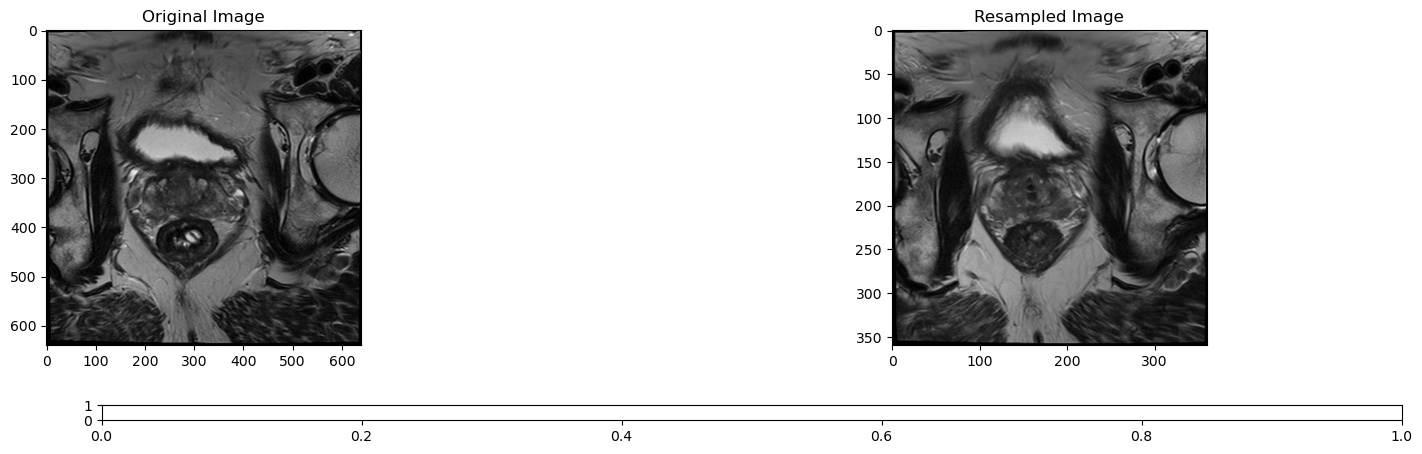

In [9]:
file_path_raw = r"Data\picai_public_images\picai_public_images_fold0\10000\10000_1000000_t2w.mha"
file_path_resampled = r"Data\t2w_spacing_resampled\resampled0\10000_1000000_t2w_resampled.mha"
image_raw = sitk.ReadImage(file_path_raw)
image_resampled = sitk.ReadImage(file_path_resampled)
image_data_raw = sitk.GetArrayFromImage(image_raw)
image_data_resampled = sitk.GetArrayFromImage(image_resampled)

print(f"Image shape: {image_data_raw.shape}")
print(f"Resampled image shape: {image_data_resampled.shape}")
print(f"Original spacing: {image_raw.GetSpacing()}")
print(f"Resampled spacing: {image_resampled.GetSpacing()}")
print(f"Intensity range: [{image_data_raw.min()}, {image_data_raw.max()}]")
print(f"Resampled intensity range: [{image_data_resampled.min()}, {image_data_resampled.max()}]")



fig, ax = plt.subplots(1, 2, figsize=(20, 5))

plt.subplots_adjust(bottom=0.25)

axlayer = plt.axes([0.25, 0.1, 0.65, 0.03])

ax[0].imshow(image_data_raw[16, :, :], cmap='gray')
ax[0].set_title("Original Image")

ax[1].imshow(image_data_resampled[16, :, :], cmap='gray')
ax[1].set_title("Resampled Image")

plt.show()


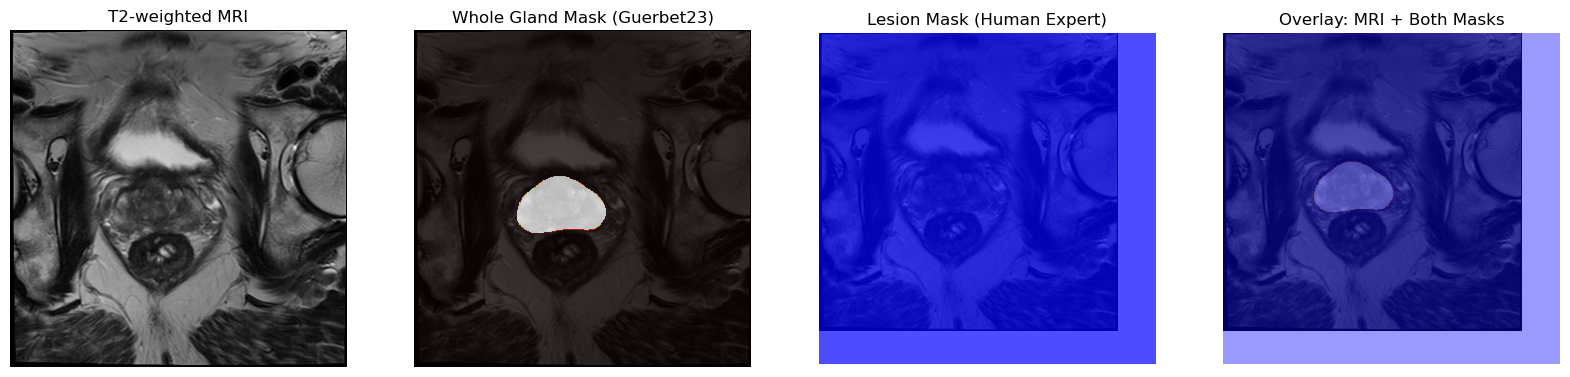

In [10]:
fileInfoT2w = '_t2w_resampled.mha'

fileInfo = '.nii.gz'
t2w_paths = find_t2W_files(source_PI_CAI_resampled, combined_ids, fileInfoT2w)
Guerbet23_nii_gz_paths = find_t2W_files(source_PI_CAI_resampled_whole_gland_Guerbet23, combined_ids, fileInfo)
Human_nii_gz_paths = find_t2W_files(source_PI_CAI_resampled_Human, combined_ids, fileInfo)

t2w_patient_ids = [path.split('\\')[-1].split("_")[0] for path in t2w_paths]
Guerbet23_patient_ids = [path.split('\\')[-1].split("_")[0] for path in Guerbet23_nii_gz_paths]
Human_nii_gz_patient_ids = [path.split('\\')[-1].split("_")[0] for path in Human_nii_gz_paths]


t2w_df = pd.DataFrame({'patient_id': t2w_patient_ids, 'T2w_path': t2w_paths})
Guerbet23_df = pd.DataFrame({'Guerbet23_path': Guerbet23_nii_gz_paths, 'patient_id': Guerbet23_patient_ids})
Human_df = pd.DataFrame({'Human_path': Human_nii_gz_paths, 'patient_id': Human_nii_gz_patient_ids})

df_path_merged_Guerbet23 = pd.merge(t2w_df, Guerbet23_df, on='patient_id')
df_path_merged_Human = pd.merge(t2w_df, Human_df, on='patient_id')
df_path_merge_human_guerbet23 = pd.merge(Guerbet23_df, Human_df, on='patient_id')

df_path_merge_human_guerbet23.to_csv("Data/merged_human_guerbet23.csv")

if not df_path_merged_Guerbet23.empty and not df_path_merged_Human.empty:
    patient_id = df_path_merged_Guerbet23.iloc[0]['patient_id'] 
    t2w_path = df_path_merged_Guerbet23.iloc[0]['T2w_path']
    guerbet23_mask_path = df_path_merged_Guerbet23.iloc[0]['Guerbet23_path']
    human_mask_path = df_path_merged_Human.iloc[0]['Human_path']

    t2w_image = load_nifti_image(t2w_path)
    guerbet23_mask = load_nifti_image(guerbet23_mask_path)
    human_mask = load_nifti_image(human_mask_path) 

    t2w_image = t2w_image / np.max(t2w_image)

    mid_slice = t2w_image.shape[0] // 2


    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    ax[0].imshow(t2w_image[mid_slice], cmap='gray')
    ax[0].set_title("T2-weighted MRI")

    ax[1].imshow(t2w_image[mid_slice], cmap='gray')
    ax[1].imshow(guerbet23_mask[mid_slice], cmap='hot', alpha=0.7)
    ax[1].set_title("Whole Gland Mask (Guerbet23)")

    ax[2].imshow(t2w_image[mid_slice], cmap='gray')
    ax[2].imshow(human_mask[mid_slice], cmap='winter', alpha=0.7)
    ax[2].set_title("Lesion Mask (Human Expert)")

    ax[3].imshow(t2w_image[mid_slice], cmap='gray')
    ax[3].imshow(guerbet23_mask[mid_slice], cmap='hot', alpha=0.4)
    ax[3].imshow(human_mask[mid_slice], cmap='winter', alpha=0.4)
    ax[3].set_title("Overlay: MRI + Both Masks")

    for a in ax:
        a.axis("off")

    plt.show()
else:
    print("Merged DataFrames are empty. Please check the input data.")

def get_path_by_patient_id(df, patient_id, column_name):
    """
    Function to get the path based on patient_id.
    
    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    patient_id (str): The patient ID to search for.
    column_name (str): The name of the column to retrieve the path from.
    
    Returns:
    str: The path if found, otherwise None.
    """
    if column_name not in df.columns:
        raise KeyError(f"Column '{column_name}' does not exist in the DataFrame.")
    
    # Convert patient_id to string to match the DataFrame's patient_id type
    patient_id = str(patient_id)
    
    # Check if the patient_id exists in the DataFrame
    if patient_id not in df['patient_id'].values:
        print(f"patient_id {patient_id} does not exist in the DataFrame.")
        return None
    
    result = df.loc[df['patient_id'] == patient_id, column_name]
    if not result.empty:
        return result.values[0]
    else:
        return None


In [88]:
guerbet23_mask_img = sitk.ReadImage(guerbet23_mask_path)
human_mask_img = sitk.ReadImage(human_mask_path)
#print(f"Whole Gland Mask shape {guerbet23_mask_img.shape}")
#print(f"Lesion Mask shape {human_mask_img.shape}")
print(f"Image size: {image_raw.GetSize()}")
print(f"Resampled image size: {image_resampled.GetSize()}")
print(f"Whole Gland Mask size: {guerbet23_mask_img.GetSize()}")
print(f"Lesion Mask size: {human_mask_img.GetSize()}")
print(f"Image spacing: {human_mask_img.GetSpacing()}")

print(f"Resampled image spacing: {image_resampled.GetSpacing()}")
print(f"Whole Gland Mask spacing: {guerbet23_mask_img.GetSpacing()}")

Image size: (640, 640, 31)
Resampled image size: (360, 360, 34)
Whole Gland Mask size: (360, 360, 34)
Lesion Mask size: (407, 400, 34)
Image spacing: (0.5, 0.5, 3.0)
Resampled image spacing: (0.5, 0.5, 3.0)
Whole Gland Mask spacing: (0.5, 0.5, 3.0)


In [12]:
def combine_images(Guerbert23_path, Human_path):

    photo = sitk.ReadImage(Guerbert23_path)
    overlay = sitk.ReadImage(Human_path)

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(photo)
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    overlay = resampler.Execute(overlay)
    overlay_resampled = resampler.Execute(overlay)
    combined_image = sitk.Cast(photo, sitk.sitkFloat32) + sitk.Cast(overlay_resampled, sitk.sitkFloat32)
    return combined_image

def check_mask(mask):
    mask_array = sitk.GetArrayFromImage(mask)
    unique_values = np.unique(mask_array)
    print(f"Unique values in mask: {unique_values}")
    if len(unique_values) <= 1:
        raise ValueError("No labels found in this mask (i.e. nothing is segmented)!")
    
def resample_mask_to_image(mask, image):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(image)
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    resampler.SetDefaultPixelValue(0)
    resampled_mask = resampler.Execute(mask)
    return resampled_mask


def align_image_and_mask(image, mask):
    mask.SetOrigin(image.GetOrigin())  # Force same origin
    mask.SetSpacing(image.GetSpacing())  # Ensure same spacing
    mask.SetDirection(image.GetDirection())  # Align orientation
    return mask
    
def extract_intensity_features(mha_folder0):
    """Extracts first-order intensity, 2D shape, and 3D shape intensity features from all .mha files in a given folder using PyRadiomics."""

    if not os.path.exists(mha_folder0):
        print(f"ERROR: Folder {mha_folder0} does not exist!")
        return
    settings_path = os.path.join('Params.yaml')
    
    extractor = featureextractor.RadiomicsFeatureExtractor(settings_path)

    data = []

    for patient_img in os.listdir(mha_folder0):
        if patient_img.endswith(".mha"):
            image_path = os.path.join(mha_folder0, patient_img)
            patient_id = patient_img.split("_")[0]
        
        else:
            print(f"Skipping {patient_id}: No .mha file found.")
            continue
        
        try: 
            Guerbet_path = get_path_by_patient_id(df_path_merge_human_guerbet23, patient_id, 'Guerbet23_path')
            if Guerbet_path is None:
                print(f"⚠️ Skipping {image_path}: Mask file {Guerbet_path} not found!")
                continue 
            

            image = sitk.ReadImage(image_path)
            mask = sitk.ReadImage(Guerbet_path)
            mask.CopyInformation(image)
            
            features = extractor.execute(image, mask)

            feature_row = {"patient_id": patient_id}
            mesh_volume = features.get("original_shape_MeshVolume", None)
            max_diameter = features.get("original_shape_Maximum3DDiameter", None)
            max2D_diameter = features.get("original_shape_Maximum2DDiameterSlice", None)

            if mesh_volume is not None and max_diameter is not None and max_diameter != 0:
                feature_row["Diameter-Volum-ratio"] = max_diameter / mesh_volume
            else:
                feature_row["Diameter-Volum-ratio"] = None

            if mesh_volume is not None and max2D_diameter is not None and max2D_diameter != 0:
                feature_row["Diameter-Volum-ratio-2D"] = max2D_diameter / mesh_volume
            else:
                feature_row["Diameter-Volum-ratio-2D"] = None

            for key, value in features.items():
                if key.startswith("original"):  # Filter out metadata keys
                    feature_row[key] = value
                    #print(key, value)
            data.append(feature_row)
        
        except Exception as e:
            print(f"Error processing {patient_id}: {e}")
    return data



In [13]:
data = []
mha_folder0 = r"Data/t2w_spacing_resampled/resampled0"
mha_folder1 = r"Data/t2w_spacing_resampled/resampled1"
mha_folder2 = r"Data/t2w_spacing_resampled/resampled2"
mha_folder3 = r"Data/t2w_spacing_resampled/resampled3"
mha_folder4 = r"Data/t2w_spacing_resampled/resampled4"
data1 = extract_intensity_features(mha_folder0)
data.extend(data1)
data2 = extract_intensity_features(mha_folder1)
data.extend(data2)
data3 = extract_intensity_features(mha_folder2)
data.extend(data3)
data4 = extract_intensity_features(mha_folder3)
data.extend(data4)
data5 = extract_intensity_features(mha_folder4)
data.extend(data5)
df = pd.DataFrame(data)
df.to_csv("features_all_patients.csv")
print("\n🎉 Feature extraction complete! Data saved to 'features_all_patients.csv'.")

gc.collect()


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10029 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\10029_1000029_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is depr

patient_id 10229 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\10229_1000233_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10282 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\10282_1000288_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is depr

patient_id 10400 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\10400_1000406_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10459 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\10459_1000467_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10501 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\10501_1000510_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10515 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\10515_1000525_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10550 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\10550_1000562_t2w_resampled.mha: Mask file None not found!
patient_id 10562 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\10562_1000574_t2w_resampled.mha: Mask file None not found!
patient_id 10565 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\10565_1000577_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is depr

patient_id 10679 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\10679_1000695_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10701 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\10701_1000717_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!


patient_id 10717 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\10717_1000733_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10753 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\10753_1000769_t2w_resampled.mha: Mask file None not found!
patient_id 10760 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\10760_1000776_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10772 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\10772_1000788_t2w_resampled.mha: Mask file None not found!
patient_id 10775 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\10775_1000791_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10862 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\10862_1000878_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10873 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\10873_1000889_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10956 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\10956_1000975_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10993 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\10993_1001012_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11045 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\11045_1001065_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11067 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\11067_1001089_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11095 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\11095_1001118_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11111 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\11111_1001134_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11157 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\11157_1001180_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11173 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\11173_1001196_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11248 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\11248_1001271_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11266 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\11266_1001289_t2w_resampled.mha: Mask file None not found!
patient_id 11285 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\11285_1001308_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11313 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\11313_1001336_t2w_resampled.mha: Mask file None not found!
patient_id 11322 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\11322_1001345_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!


patient_id 11332 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\11332_1001355_t2w_resampled.mha: Mask file None not found!
patient_id 11334 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\11334_1001357_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!


patient_id 11341 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\11341_1001364_t2w_resampled.mha: Mask file None not found!
patient_id 11346 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\11346_1001369_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!


patient_id 11352 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\11352_1001375_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11400 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\11400_1001424_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!


patient_id 11425 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\11425_1001449_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11451 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled0\11451_1001475_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10008 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10008_1000008_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10036 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10036_1000036_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10053 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10053_1000053_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10106 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10106_1000106_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10112 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10112_1000112_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10182 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10182_1000185_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10209 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10209_1000213_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10280 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10280_1000285_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10334 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10334_1000340_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10377 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10377_1000383_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is depr

patient_id 10494 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10494_1000503_t2w_resampled.mha: Mask file None not found!
patient_id 10496 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10496_1000505_t2w_resampled.mha: Mask file None not found!
patient_id 10498 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10498_1000507_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10555 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10555_1000567_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10567 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10567_1000579_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10622 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10622_1000636_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!


patient_id 10630 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10630_1000645_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10742 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10742_1000758_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10799 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10799_1000815_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10806 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10806_1000822_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!


patient_id 10811 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10811_1000827_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10882 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10882_1000898_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10894 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10894_1000910_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!


patient_id 10909 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10909_1000926_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10943 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10943_1000962_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10965 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\10965_1000984_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11043 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\11043_1001063_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11083 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\11083_1001105_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is depr

patient_id 11274 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\11274_1001297_t2w_resampled.mha: Mask file None not found!
patient_id 11283 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\11283_1001306_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11350 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\11350_1001373_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11369 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\11369_1001392_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11437 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\11437_1001461_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11468 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled1\11468_1001492_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is depr

patient_id 10132 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10132_1000134_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10170 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10170_1000173_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


Error processing 10233: Exception thrown in SimpleITK Image_CopyInformation: D:\bld\libsimpleitk_1736714910710\work\Code\Common\src\sitkImage.cxx:356:
sitk::ERROR: Source image size of [ 360, 360, 39 ] does not match this image's size of [ 360, 360, 38 ]!


Feature Compactness1 is deprecated, use with caution!


patient_id 10235 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10235_1000239_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10312 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10312_1000318_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10318 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10318_1000324_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10369 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10369_1000375_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10393 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10393_1000399_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10402 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10402_1000408_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10408 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10408_1000415_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10431 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10431_1000439_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10456 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10456_1000464_t2w_resampled.mha: Mask file None not found!
patient_id 10458 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10458_1000466_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10471 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10471_1000479_t2w_resampled.mha: Mask file None not found!
patient_id 10481 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10481_1000489_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10508 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10508_1000517_t2w_resampled.mha: Mask file None not found!
patient_id 10517 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10517_1000527_t2w_resampled.mha: Mask file None not found!
patient_id 10520 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10520_1000530_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10537 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10537_1000547_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10545 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10545_1000556_t2w_resampled.mha: Mask file None not found!
patient_id 10554 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10554_1000566_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10584 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10584_1000598_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10631 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10631_1000646_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!


patient_id 10644 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10644_1000660_t2w_resampled.mha: Mask file None not found!
patient_id 10652 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10652_1000668_t2w_resampled.mha: Mask file None not found!
patient_id 10658 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10658_1000674_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!


patient_id 10660 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10660_1000676_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10684 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10684_1000700_t2w_resampled.mha: Mask file None not found!
patient_id 10686 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10686_1000702_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10693 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10693_1000709_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!


patient_id 10710 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10710_1000726_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10718 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10718_1000734_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10739 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10739_1000755_t2w_resampled.mha: Mask file None not found!
patient_id 10758 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10758_1000774_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


Error processing 10787: Exception thrown in SimpleITK Image_CopyInformation: D:\bld\libsimpleitk_1736714910710\work\Code\Common\src\sitkImage.cxx:356:
sitk::ERROR: Source image size of [ 384, 384, 29 ] does not match this image's size of [ 384, 384, 28 ]!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10797 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10797_1000813_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10852 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10852_1000868_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10883 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10883_1000899_t2w_resampled.mha: Mask file None not found!
patient_id 10890 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10890_1000906_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10976 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\10976_1000995_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11037 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\11037_1001057_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is depr

patient_id 11117 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\11117_1001140_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11146 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\11146_1001169_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is depr

patient_id 11243 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\11243_1001266_t2w_resampled.mha: Mask file None not found!
patient_id 11245 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\11245_1001268_t2w_resampled.mha: Mask file None not found!
patient_id 11258 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\11258_1001281_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11333 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\11333_1001356_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11367 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\11367_1001390_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11426 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled2\11426_1001450_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10050 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10050_1000050_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10100 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10100_1000100_t2w_resampled.mha: Mask file None not found!
patient_id 10104 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10104_1000104_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10140 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10140_1000142_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!


patient_id 10148 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10148_1000150_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10236 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10236_1000240_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10283 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10283_1000289_t2w_resampled.mha: Mask file None not found!
patient_id 10293 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10293_1000299_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10324 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10324_1000330_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10371 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10371_1000377_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10376 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10376_1000382_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10433 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10433_1000441_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10465 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10465_1000473_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is depr

patient_id 10577 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10577_1000590_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10606 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10606_1000620_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10636 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10636_1000652_t2w_resampled.mha: Mask file None not found!
patient_id 10638 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10638_1000654_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!


patient_id 10651 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10651_1000667_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10682 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10682_1000698_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is depr

patient_id 10763 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10763_1000779_t2w_resampled.mha: Mask file None not found!
patient_id 10773 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10773_1000789_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!


patient_id 10781 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10781_1000797_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10810 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10810_1000826_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10827 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10827_1000843_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10845 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10845_1000861_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!


patient_id 10856 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10856_1000872_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!


patient_id 10865 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10865_1000881_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is depr

patient_id 10991 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\10991_1001010_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11055 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\11055_1001076_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11072 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\11072_1001094_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!


patient_id 11081 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\11081_1001103_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11123 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\11123_1001146_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!


patient_id 11133 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\11133_1001156_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11169 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\11169_1001192_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11240 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\11240_1001263_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11296 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\11296_1001319_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!


patient_id 11302 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\11302_1001325_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is depr

patient_id 11472 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled3\11472_1001496_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10013 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10013_1000013_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10044 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10044_1000044_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10094 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10094_1000094_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10135 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10135_1000137_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10171 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10171_1000174_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10212 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10212_1000216_t2w_resampled.mha: Mask file None not found!
patient_id 10214 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10214_1000218_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10225 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10225_1000229_t2w_resampled.mha: Mask file None not found!
patient_id 10232 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10232_1000236_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10271 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10271_1000275_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10354 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10354_1000360_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!


patient_id 10358 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10358_1000364_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10365 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10365_1000371_t2w_resampled.mha: Mask file None not found!
patient_id 10375 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10375_1000381_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10397 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10397_1000403_t2w_resampled.mha: Mask file None not found!
patient_id 10399 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10399_1000405_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10426 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10426_1000434_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10464 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10464_1000472_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10497 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10497_1000506_t2w_resampled.mha: Mask file None not found!
patient_id 10499 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10499_1000508_t2w_resampled.mha: Mask file None not found!
patient_id 10510 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10510_1000519_t2w_resampled.mha: Mask file None not found!
patient_id 10519 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10519_1000529_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10547 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10547_1000558_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!


patient_id 10560 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10560_1000572_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10611 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10611_1000625_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10661 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10661_1000677_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10690 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10690_1000706_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10754 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10754_1000770_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10837 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10837_1000853_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10857 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10857_1000873_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10875 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10875_1000891_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10889 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10889_1000905_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10900 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10900_1000916_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!


patient_id 10903 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10903_1000919_t2w_resampled.mha: Mask file None not found!
patient_id 10904 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10904_1000920_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 10995 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\10995_1001014_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11009 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\11009_1001029_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11093 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\11093_1001116_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11115 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\11115_1001138_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11143 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\11143_1001166_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11179 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\11179_1001202_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11207 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\11207_1001230_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11239 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\11239_1001262_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!


patient_id 11336 does not exist in the DataFrame.
⚠️ Skipping Data/t2w_spacing_resampled/resampled4\11336_1001359_t2w_resampled.mha: Mask file None not found!


Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is deprecated, use with caution!
Feature Compactness1 is depr


🎉 Feature extraction complete! Data saved to 'features_all_patients.csv'.


10851

In [24]:
Guidelines = []
def create_promt( guideline, feature_name, radiomic_feature_ex, feature_value):
    
    Guideline = f"{guideline} \n {feature_name}, {radiomic_feature_ex}\n {feature_name} value: {feature_value}"
    Guidelines.append(Guideline)
    return Guidelines

Signal = "Signal intensity: T2WI guidelines mention that hypointense lesions are often high-grade and indicative of potential malignancy."
Tumor = "Tumor size: Lesion size is an important factor in determining risk. Lesions larger than 1 cm are more likely to be significant."
Shape = "Shape of the tumor: Irregular or lenticular shapes are more likely to be associated with high-grade tumors."
Margins = "Margins of the tumor: Poorly defined margins indicate a higher likelihood of extraprostatic extension (EPE)."
Extraprostatic = "Extraprostatic extension: Indicates advanced disease with infiltration beyond the prostate."

Mean_intensity = "lower indicates hypointense"
Skweness = "negative indicates dark lesions"
Kurtosis = "highly concentrated lesions in a small intensity range"
Histogram_based = ""

Volume = "larger lesions have higher volumes"
Surface_area = "correlated to volume"
Diameter = ""
Diameter_to_volume_ratio = ""

Sphericity = "Low for irregularity"
Elongation = "high can indicate more irregularity"
Compactness = "how close the lesion is to being spherical - non-compact is often associated with more aggressive"

Surface_Area_to_Volume_ratio = "higher are likely to have poor defined boundaries"
Entropy = "high indicates heterogeneity which means poorly defined margins"
GLCM = "e.g contrast indicates heterogeneous intensity"

GLSZM = "(Gray-level size zone matrix), texture variations at the tumor boundary, which can be indicative of extraprostatic extension"
GLRLM = "(Gray-level run length), texture variations at the tumor boundary, which can be indicative of extraprostatic extension"
NGTDM = "Lower values indicate sharper transitions and finer edges. Higher values suggest irregular borders (more coarse and with higher contrast) and also “more disorganized tissue”, which can be correlated to more invasive tumors. "

def create_guidelines_csv(features, output_path):
    features_df = pd.read_csv(features)

    feature_mapping = {
        "Volume": "original_shape_MeshVolume",
        "Surface_area": "original_shape_SurfaceArea",
        "Diameter": "original_shape_Maximum3DDiameter",
        "Histogram_based": "original_firstorder_Uniformity",
        "Diameter_to_volume_ratio": "Diameter-Volum-ratio",
        "Diameter_to_volume_ratio_2D": "Diameter-Volum-ratio-2D",
        "Mean intensity": "original_firstorder_Mean",
        "Skweness": "original_firstorder_Skewness",
        "Kurtosis": "original_firstorder_Kurtosis",
        "Entropy": "original_firstorder_Entropy",
        "Sphericity": "original_shape_Sphericity",
        "Elongation": "original_shape_Elongation",
        "Compactness": "original_shape_Compactness1",
        "Surface_Area_to_Volume_ratio": "original_shape_SurfaceVolumeRatio",
        "GLCM": "original_glcm_Contrast",
        "GLRLM": "original_glrlm_RunEntropy",
        "GLSZM": "original_glszm_ZoneEntropy",
        "NGTDM_Coarseness": "original_ngtdm_Coarseness",
        "NGTDM_Contrast": "original_ngtdm_Contrast"

    }
    guidelines = [
        {"guideline": "Signal intensity: T2WI guidelines mention that hypointense lesions are often high-grade and indicative of potential malignancy.",
         "feature_name": "Mean intensity", "feature_context": "lower indicates hypointense"},
         {"guideline": "Signal intensity: T2WI guidelines mention that hypointense lesions are often high-grade and indicative of potential malignancy.",
         "feature_name": "Skweness", "feature_context": "negative indicates dark lesions"},
         {"guideline": "Signal intensity: T2WI guidelines mention that hypointense lesions are often high-grade and indicative of potential malignancy.",
          "feature_name": "Kurtosis", "feature_context": "highly concentrated lesions in a small intensity range"},
         {"guideline": "Signal intensity: T2WI guidelines mention that hypointense lesions are often high-grade and indicative of potential malignancy.",
          "feature_name": "Histogram_based", "feature_context": "Histogram based features can provide information on the distribution of intensity values"},
         {"guideline": "Tumor size: Lesion size is an important factor in determining risk. Lesions larger than 1 cm are more likely to be significant.",
          "feature_name": "Volume", "feature_context": "larger lesions have higher volumes"},
         {"guideline": "Tumor size: Lesion size is an important factor in determining risk. Lesions larger than 1 cm are more likely to be significant.",
          "feature_name": "Surface_area", "feature_context": "correlated to volume"},
         {"guideline": "Tumor size: Lesion size is an important factor in determining risk. Lesions larger than 1 cm are more likely to be significant.",
          "feature_name": "Diameter", "feature_context": "Diameter of the lesion"},
         {"guideline": "Tumor size: Lesion size is an important factor in determining risk. Lesions larger than 1 cm are more likely to be significant.",
          "feature_name": "Diameter_to_volume_ratio", "feature_context": "Ratio between diameter and volume"},
          {"guideline": "Tumor size: Lesion size is an important factor in determining risk. Lesions larger than 1 cm are more likely to be significant.",
           "feature_name": "Diameter_to_volume_ratio_2D", "feature_context": "Ratio between diameter and volume in 2D"},
         {"guideline": "Shape of the tumor: Irregular or lenticular shapes are more likely to be associated with high-grade tumors.",
          "feature_name": "Sphericity", "feature_context": "Low for irregularity"},
         {"guideline": "Shape of the tumor: Irregular or lenticular shapes are more likely to be associated with high-grade tumors.",
          "feature_name": "Elongation", "feature_context": "high can indicate more irregularity"},
         {"guideline": "Shape of the tumor: Irregular or lenticular shapes are more likely to be associated with high-grade tumors.",
          "feature_name": "Compactness", "feature_context": "how close the lesion is to being spherical - non-compact is often associated with more aggressive"},
         {"guideline": "Shape of the tumor: Irregular or lenticular shapes are more likely to be associated with high-grade tumors.",
          "feature_name": "Shape_index", "feature_context": "Shape of the index"},
         {"guideline": "Margins of the tumor: Poorly defined margins indicate a higher likelihood of extraprostatic extension (EPE).",
          "feature_name": "Surface_Area_to_Volume_ratio", "feature_context": "higher are likely to have poor defined boundaries"},
         {"guideline": "Margins of the tumor: Poorly defined margins indicate a higher likelihood of extraprostatic extension (EPE).",
          "feature_name": "Entropy", "feature_context": "high indicates heterogeneity which means poorly defined margins"},
         {"guideline": "Margins of the tumor: Poorly defined margins indicate a higher likelihood of extraprostatic extension (EPE).",
          "feature_name": "GLCM", "feature_context": "e.g contrast indicates heterogeneous intensity"},
         {"guideline": "Extraprostatic extension: Indicates advanced disease with infiltration beyond the prostate.",
          "feature_name": "Edge_sharpness", "feature_context": "irregular boundaries"},
         {"guideline": "Extraprostatic extension: Indicates advanced disease with infiltration beyond the prostate.",
          "feature_name": "GLSZM", "feature_context": "(Gray-level size zone matrix), texture variations at the tumor boundary, which can be indicative of extraprostatic extension"},
         {"guideline": "Extraprostatic extension: Indicates advanced disease with infiltration beyond the prostate.",
          "feature_name": "GLRLM", "feature_context": "(Gray-level run length), texture variations at the tumor boundary, which can be indicative of extraprostatic extension"},
         {"guideline": "Extraprostatic extension: Indicates advanced disease with infiltration beyond the prostate.",
          "feature_name": "NGTDM_Coarseness", "feature_context": "Lower values indicate sharper transitions and finer edges. Higher values suggest irregular borders (more coarse and with higher contrast) and also “more disorganized tissue”, which can be correlated to more invasive tumors. "},
          {"guideline": "Extraprostatic extension: Indicates advanced disease with infiltration beyond the prostate.",
          "feature_name": "NGTDM_Contrast", "feature_context": "Lower values indicate sharper transitions and finer edges. Higher values suggest irregular borders (more coarse and with higher contrast) and also “more disorganized tissue”, which can be correlated to more invasive tumors. "}    
    ]
    rows = []

    for _, patient_row in features_df.iterrows():
        patient_id = int(patient_row["patient_id"])

        for guideline in guidelines:
            feature_name = guideline["feature_name"]
            csv_column = feature_mapping.get(feature_name)
            feature_value = patient_row.get(csv_column, None)
            if feature_value is not None:
                row = {
                    "patient_id": patient_id,
                    "guideline": guideline["guideline"],
                    "feature_name": feature_name,
                    "feature_value": feature_value,
                    "feature_context": guideline["feature_context"]
                }
                rows.append(row)
    guidelines_df = pd.DataFrame(rows)
    guidelines_df.to_csv(output_path, index=False)
    print(f"\n🎉 Guidelines CSV file created and saved to '{output_path}'.")

features_csv = "features_all_patients.csv"
output_path = "guidelines_with_features.csv"
create_guidelines_csv(features_csv, output_path)


🎉 Guidelines CSV file created and saved to 'guidelines_with_features.csv'.


In [25]:
Model_name = "dmis-lab/biobert-v1.1"
tokenizer = AutoTokenizer.from_pretrained(Model_name)
model = AutoModel.from_pretrained(Model_name)

df = pd.read_csv("guidelines_with_features.csv")


def get_embedding(text, feature_value):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    text_embeddings = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    feature_value_array = np.array([feature_value], dtype=np.float32)
    combined_embedding = np.concatenate([text_embeddings, feature_value_array])
    return combined_embedding

df["embedding"] = df.apply(lambda x: get_embedding(x["guideline"] + " " + x["feature_name"] + " " + x["feature_context"], x["feature_value"]), axis=1)

df.to_pickle("biobert_embeddings.pkl")

In [26]:
df.head()

,patient_id,guideline,feature_name,feature_value,feature_context,embedding
0,10000,Signal intensity: T2WI guidelines mention that...,Mean intensity,0.171017,lower indicates hypointense,"[0.1736704, -0.2612529, 0.35782945, 0.02057409..."
1,10000,Signal intensity: T2WI guidelines mention that...,Skweness,0.836473,negative indicates dark lesions,"[0.2667624, -0.2850996, 0.23743401, 0.01160193..."
2,10000,Signal intensity: T2WI guidelines mention that...,Kurtosis,4.693329,highly concentrated lesions in a small intensi...,"[0.08311045, -0.07760742, 0.15329805, 0.076546..."
3,10000,Signal intensity: T2WI guidelines mention that...,Histogram_based,0.049434,Histogram based features can provide informati...,"[-0.082264476, 0.083576344, 0.005076249, 0.111..."
4,10000,Tumor size: Lesion size is an important factor...,Volume,29921.625000,larger lesions have higher volumes,"[0.016640194, 0.25996196, -0.3138533, -0.23772..."


In [53]:
df = pd.read_pickle("biobert_embeddings.pkl")
df["embedding"] = df["embedding"].apply(lambda x: np.array(x))
X = np.vstack(df["embedding"].values)
marksheet = pd.read_csv("Data/marksheet.csv")

df['case_csPCa'] = marksheet['case_csPCa'].apply(lambda x: 1 if x.upper() == 'YES' else 0)
df = df.dropna(subset=["case_csPCa"])
y = df['case_csPCa'].values
df.head()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)



LR = LogisticRegression()
LR.fit(X_train, y_train)
y_pred_cv = cross_val_predict(LR, X_train, y_train, cv=5)
print("Cross-validation results:")
print(classification_report(y_train, y_pred_cv))


ValueError: Found input variables with inconsistent numbers of samples: [24149, 1500]